# Actor-Critic: Combining Policy and Value Methods

> **"Actor-Critic methods combine the best of both policy and value approaches."**

## Learning Objectives
- Understand the actor-critic architecture and its advantages
- Implement A2C (Advantage Actor-Critic) from scratch
- Learn about advantage estimation and variance reduction
- Master modern actor-critic algorithms (A3C, PPO, SAC)
- Apply actor-critic methods to complex RL problems


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Actor-Critic Methods

### What are Actor-Critic Methods?
Actor-Critic methods combine the benefits of both policy gradient methods (actor) and value function methods (critic). The actor learns the policy, while the critic learns the value function to provide better estimates for policy updates.

### Key Components

#### 1. Actor (Policy)
- Learns the policy π(a|s)
- Updated using policy gradient with value function estimates

#### 2. Critic (Value Function)
- Learns the state-value function V(s) or action-value function Q(s,a)
- Provides better estimates for policy updates

#### 3. Advantage Function
A(s,a) = Q(s,a) - V(s) measures how much better an action is compared to the average.

## 2. Environment and Supporting Classes

### Grid World Environment for Policy Gradient
class GridWorldPG:
    """Grid world environment for policy gradient methods."""
    
    def __init__(self, size=4):
        self.size = size
        self.n_states = size * size
        self.n_actions = 4  # Up, Down, Left, Right
        
        # Define grid
        self.grid = np.zeros((size, size))
        self.start_pos = (0, 0)
        self.goal_pos = (size-1, size-1)
        self.current_pos = self.start_pos
        
        # Actions: 0=Up, 1=Down, 2=Left, 3=Right
        self.action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
    def reset(self):
        """Reset environment to initial state."""
        self.current_pos = self.start_pos
        return self._pos_to_state(self.current_pos)
    
    def _pos_to_state(self, pos):
        """Convert position to state index."""
        return pos[0] * self.size + pos[1]
    
    def _state_to_pos(self, state):
        """Convert state index to position."""
        return (state // self.size, state % self.size)
    
    def step(self, action):
        """Take a step in the environment."""
        # Calculate new position
        new_row = self.current_pos[0] + self.action_effects[action][0]
        new_col = self.current_pos[1] + self.action_effects[action][1]
        
        # Check boundaries
        if 0 <= new_row < self.size and 0 <= new_col < self.size:
            self.current_pos = (new_row, new_col)
        
        # Calculate reward
        if self.current_pos == self.goal_pos:
            reward = 100  # Goal reached
            done = True
        else:
            reward = -1   # Step penalty
            done = False
        
        return self._pos_to_state(self.current_pos), reward, done

### REINFORCE Agent for Comparison
class REINFORCEAgent:
    """REINFORCE policy gradient agent implementation."""
    
    def __init__(self, n_states, n_actions, learning_rate=0.01, gamma=0.99):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        
        # Initialize policy parameters (weights for each state-action pair)
        self.theta = np.random.randn(n_states, n_actions) * 0.1
        
    def softmax_policy(self, state):
        """Compute policy using softmax function."""
        # Get logits for current state
        logits = self.theta[state]
        
        # Apply softmax to get probabilities
        exp_logits = np.exp(logits - np.max(logits))  # Subtract max for numerical stability
        probabilities = exp_logits / np.sum(exp_logits)
        
        return probabilities
    
    def select_action(self, state):
        """Select action according to current policy."""
        probabilities = self.softmax_policy(state)
        action = np.random.choice(self.n_actions, p=probabilities)
        return action
    
    def compute_returns(self, rewards, gamma):
        """Compute discounted returns for each timestep."""
        returns = []
        G = 0
        
        # Compute returns backwards
        for reward in reversed(rewards):
            G = reward + gamma * G
            returns.insert(0, G)
        
        return returns
    
    def update_policy(self, states, actions, returns):
        """Update policy parameters using REINFORCE algorithm."""
        for state, action, G in zip(states, actions, returns):
            # Get current policy probabilities
            probabilities = self.softmax_policy(state)
            
            # Compute policy gradient
            # ∇log π(a|s) = 1 - π(a|s) for the selected action
            # ∇log π(a'|s) = -π(a'|s) for other actions
            policy_gradient = np.zeros(self.n_actions)
            policy_gradient[action] = 1 - probabilities[action]
            
            # Update parameters
            self.theta[state] += self.learning_rate * G * policy_gradient

# Train REINFORCE agent function
def train_reinforce(agent, env, episodes=1000):
    """Train REINFORCE agent on the environment."""
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(episodes):
        # Generate episode
        states = []
        actions = []
        rewards = []
        
        state = env.reset()
        done = False
        steps = 0
        max_steps = 100
        
        while not done and steps < max_steps:
            # Select action
            action = agent.select_action(state)
            
            # Take step
            next_state, reward, done = env.step(action)
            
            # Store experience
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            
            # Update state
            state = next_state
            steps += 1
        
        # Compute returns
        returns = agent.compute_returns(rewards, agent.gamma)
        
        # Update policy
        agent.update_policy(states, actions, returns)
        
        # Store episode statistics
        episode_rewards.append(sum(rewards))
        episode_lengths.append(steps)
        
        # Print progress
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
    
    return episode_rewards, episode_lengths

print("Environment and supporting classes defined successfully!")


In [5]:


### Grid World Environment for Policy Gradient
class GridWorldPG:
    """Grid world environment for policy gradient methods."""
    
    def __init__(self, size=4):
        self.size = size
        self.n_states = size * size
        self.n_actions = 4  # Up, Down, Left, Right
        
        # Define grid
        self.grid = np.zeros((size, size))
        self.start_pos = (0, 0)
        self.goal_pos = (size-1, size-1)
        self.current_pos = self.start_pos
        
        # Actions: 0=Up, 1=Down, 2=Left, 3=Right
        self.action_effects = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        
    def reset(self):
        """Reset environment to initial state."""
        self.current_pos = self.start_pos
        return self._pos_to_state(self.current_pos)
    
    def _pos_to_state(self, pos):
        """Convert position to state index."""
        return pos[0] * self.size + pos[1]
    
    def _state_to_pos(self, state):
        """Convert state index to position."""
        return (state // self.size, state % self.size)
    
    def step(self, action):
        """Take a step in the environment."""
        # Calculate new position
        new_row = self.current_pos[0] + self.action_effects[action][0]
        new_col = self.current_pos[1] + self.action_effects[action][1]
        
        # Check boundaries
        if 0 <= new_row < self.size and 0 <= new_col < self.size:
            self.current_pos = (new_row, new_col)
        
        # Calculate reward
        if self.current_pos == self.goal_pos:
            reward = 100  # Goal reached
            done = True
        else:
            reward = -1   # Step penalty
            done = False
        
        return self._pos_to_state(self.current_pos), reward, done

### REINFORCE Agent for Comparison
class REINFORCEAgent:
    """REINFORCE policy gradient agent implementation."""
    
    def __init__(self, n_states, n_actions, learning_rate=0.01, gamma=0.99):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate = learning_rate
        self.gamma = gamma
        
        # Initialize policy parameters (weights for each state-action pair)
        self.theta = np.random.randn(n_states, n_actions) * 0.1
        
    def softmax_policy(self, state):
        """Compute policy using softmax function."""
        # Get logits for current state
        logits = self.theta[state]
        
        # Apply softmax to get probabilities
        exp_logits = np.exp(logits - np.max(logits))  # Subtract max for numerical stability
        probabilities = exp_logits / np.sum(exp_logits)
        
        return probabilities
    
    def select_action(self, state):
        """Select action according to current policy."""
        probabilities = self.softmax_policy(state)
        action = np.random.choice(self.n_actions, p=probabilities)
        return action
    
    def compute_returns(self, rewards, gamma):
        """Compute discounted returns for each timestep."""
        returns = []
        G = 0
        
        # Compute returns backwards
        for reward in reversed(rewards):
            G = reward + gamma * G
            returns.insert(0, G)
        
        return returns
    
    def update_policy(self, states, actions, returns):
        """Update policy parameters using REINFORCE algorithm."""
        for state, action, G in zip(states, actions, returns):
            # Get current policy probabilities
            probabilities = self.softmax_policy(state)
            
            # Compute policy gradient
            # ∇log π(a|s) = 1 - π(a|s) for the selected action
            # ∇log π(a'|s) = -π(a'|s) for other actions
            policy_gradient = np.zeros(self.n_actions)
            policy_gradient[action] = 1 - probabilities[action]
            
            # Update parameters
            self.theta[state] += self.learning_rate * G * policy_gradient

# Train REINFORCE agent function
def train_reinforce(agent, env, episodes=1000):
    """Train REINFORCE agent on the environment."""
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(episodes):
        # Generate episode
        states = []
        actions = []
        rewards = []
        
        state = env.reset()
        done = False
        steps = 0
        max_steps = 100
        
        while not done and steps < max_steps:
            # Select action
            action = agent.select_action(state)
            
            # Take step
            next_state, reward, done = env.step(action)
            
            # Store experience
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            
            # Update state
            state = next_state
            steps += 1
        
        # Compute returns
        returns = agent.compute_returns(rewards, agent.gamma)
        
        # Update policy
        agent.update_policy(states, actions, returns)
        
        # Store episode statistics
        episode_rewards.append(sum(rewards))
        episode_lengths.append(steps)
        
        # Print progress
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
    
    return episode_rewards, episode_lengths

print("Environment and supporting classes defined successfully!")


Environment and supporting classes defined successfully!


In [6]:
class ActorCriticAgent:
    """Actor-Critic agent implementation."""
    
    def __init__(self, n_states, n_actions, learning_rate_actor=0.01, 
                 learning_rate_critic=0.01, gamma=0.99):
        self.n_states = n_states
        self.n_actions = n_actions
        self.learning_rate_actor = learning_rate_actor
        self.learning_rate_critic = learning_rate_critic
        self.gamma = gamma
        
        # Actor parameters (policy)
        self.theta = np.random.randn(n_states, n_actions) * 0.1
        
        # Critic parameters (value function)
        self.w = np.random.randn(n_states) * 0.1
        
    def softmax_policy(self, state):
        """Compute policy using softmax function."""
        logits = self.theta[state]
        exp_logits = np.exp(logits - np.max(logits))
        probabilities = exp_logits / np.sum(exp_logits)
        return probabilities
    
    def select_action(self, state):
        """Select action according to current policy."""
        probabilities = self.softmax_policy(state)
        action = np.random.choice(self.n_actions, p=probabilities)
        return action
    
    def value_function(self, state):
        """Compute state value function."""
        return self.w[state]
    
    def update_actor(self, state, action, advantage):
        """Update actor (policy) parameters."""
        probabilities = self.softmax_policy(state)
        
        # Policy gradient
        policy_gradient = np.zeros(self.n_actions)
        policy_gradient[action] = 1 - probabilities[action]
        
        # Update parameters
        self.theta[state] += self.learning_rate_actor * advantage * policy_gradient
    
    def update_critic(self, state, target_value):
        """Update critic (value function) parameters."""
        current_value = self.value_function(state)
        td_error = target_value - current_value
        
        # Update parameters
        self.w[state] += self.learning_rate_critic * td_error

print("Actor-Critic agent class defined successfully!")


Actor-Critic agent class defined successfully!


Training Actor-Critic agent...
Episode 0, Average Reward: 64.00
Episode 100, Average Reward: 75.72
Episode 200, Average Reward: 89.73
Episode 300, Average Reward: 92.18
Episode 400, Average Reward: 93.92
Episode 500, Average Reward: 94.64
Episode 600, Average Reward: 94.85
Episode 700, Average Reward: 94.93
Episode 800, Average Reward: 94.96
Episode 900, Average Reward: 94.96


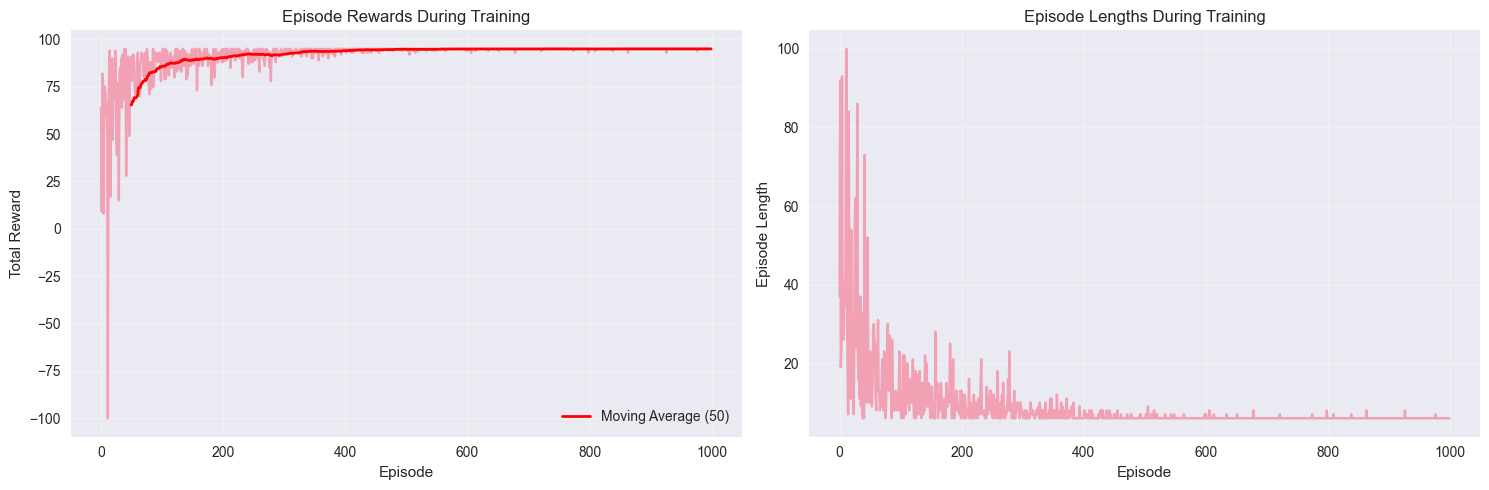


Training completed!
Final average reward (last 100 episodes): 94.97
Final average episode length: 6.03

Comparing Actor-Critic with REINFORCE:
Episode 0, Average Reward: 57.00
Episode 100, Average Reward: 88.89
Episode 200, Average Reward: 94.54
Episode 300, Average Reward: 94.93
Episode 400, Average Reward: 94.84
Episode 500, Average Reward: 94.90
Episode 600, Average Reward: 94.78
Episode 700, Average Reward: 94.98
Episode 800, Average Reward: 94.91
Episode 900, Average Reward: 94.96


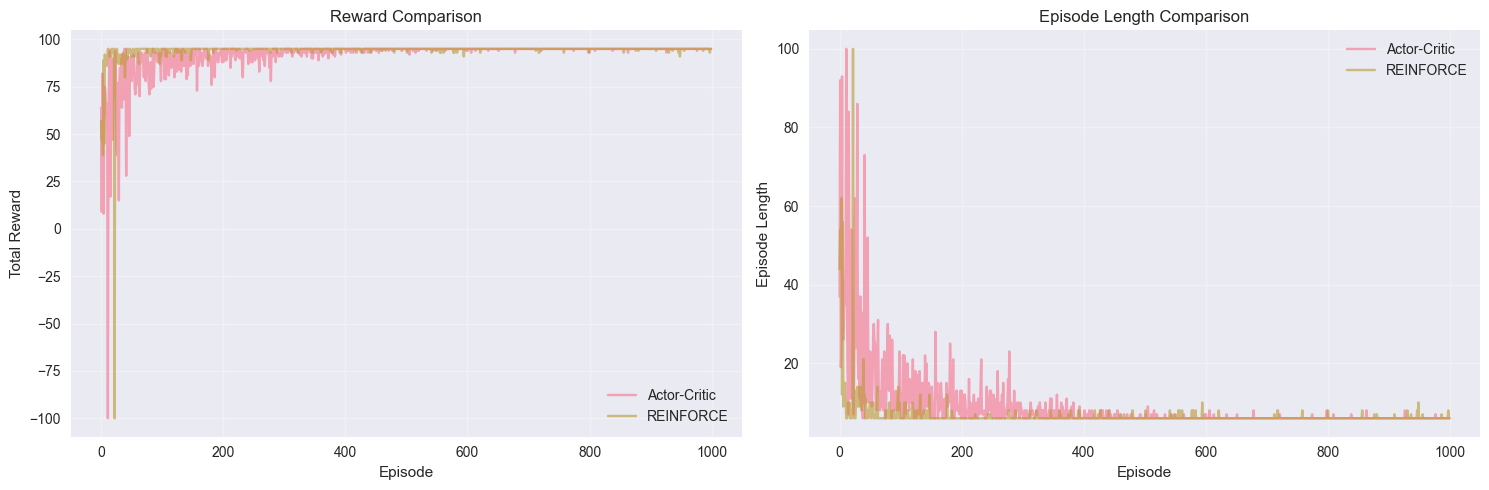

Actor-Critic final average reward: 94.97
REINFORCE final average reward: 94.86


In [7]:
# Train Actor-Critic agent
def train_actor_critic(agent, env, episodes=1000):
    """Train Actor-Critic agent on the environment."""
    episode_rewards = []
    episode_lengths = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        steps = 0
        max_steps = 100
        total_reward = 0
        
        while not done and steps < max_steps:
            # Select action
            action = agent.select_action(state)
            
            # Take step
            next_state, reward, done = env.step(action)
            
            # Compute target value
            if done:
                target_value = reward
            else:
                target_value = reward + agent.gamma * agent.value_function(next_state)
            
            # Compute advantage
            current_value = agent.value_function(state)
            advantage = target_value - current_value
            
            # Update critic
            agent.update_critic(state, target_value)
            
            # Update actor
            agent.update_actor(state, action, advantage)
            
            # Update state and tracking variables
            state = next_state
            total_reward += reward
            steps += 1
        
        # Store episode statistics
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
        
        # Print progress
        if episode % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(f"Episode {episode}, Average Reward: {avg_reward:.2f}")
    
    return episode_rewards, episode_lengths

# Create environment and agent
env = GridWorldPG(size=4)
agent = ActorCriticAgent(n_states=env.n_states, n_actions=env.n_actions, 
                        learning_rate_actor=0.01, learning_rate_critic=0.01, gamma=0.99)

print("Training Actor-Critic agent...")
print("=" * 50)

# Train the agent
episode_rewards, episode_lengths = train_actor_critic(agent, env, episodes=1000)

# Plot training progress
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot episode rewards
axes[0].plot(episode_rewards, alpha=0.6)
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Total Reward')
axes[0].set_title('Episode Rewards During Training')
axes[0].grid(True, alpha=0.3)

# Plot moving average
window = 50
if len(episode_rewards) >= window:
    moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(episode_rewards)), moving_avg, 'r-', linewidth=2, label=f'Moving Average ({window})')
    axes[0].legend()

# Plot episode lengths
axes[1].plot(episode_lengths, alpha=0.6)
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Episode Length')
axes[1].set_title('Episode Lengths During Training')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining completed!")
print(f"Final average reward (last 100 episodes): {np.mean(episode_rewards[-100:]):.2f}")
print(f"Final average episode length: {np.mean(episode_lengths[-100:]):.2f}")

# Compare with REINFORCE
print("\nComparing Actor-Critic with REINFORCE:")
print("=" * 50)

# Train REINFORCE agent for comparison
reinforce_agent = REINFORCEAgent(n_states=env.n_states, n_actions=env.n_actions, 
                                learning_rate=0.01, gamma=0.99)
reinforce_rewards, reinforce_lengths = train_reinforce(reinforce_agent, env, episodes=1000)

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_rewards, alpha=0.6, label='Actor-Critic')
plt.plot(reinforce_rewards, alpha=0.6, label='REINFORCE')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(episode_lengths, alpha=0.6, label='Actor-Critic')
plt.plot(reinforce_lengths, alpha=0.6, label='REINFORCE')
plt.xlabel('Episode')
plt.ylabel('Episode Length')
plt.title('Episode Length Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Actor-Critic final average reward: {np.mean(episode_rewards[-100:]):.2f}")
print(f"REINFORCE final average reward: {np.mean(reinforce_rewards[-100:]):.2f}")
